Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [3]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from pandas_profiling import ProfileReport

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train = pd.merge(pd.read_csv('train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv('train_labels.csv', na_values=[0, -2.000000e-08]))
test = pd.read_csv('test_features.csv', na_values=[0, -2.000000e-08])

def wrangle(df):

  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Create age feature
  df['date_recorded'] = pd.to_datetime(df['date_recorded'])
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of null values
  df.drop(columns='num_private', inplace=True)

  #Drop columns
  df.drop(columns = ['construction_year', 'waterpoint_type_group', 'extraction_type_group',
                     'extraction_type', 'payment_type', 'source_type', 'source_class', 'region_code',
                     'water_quality', 'management_group', 'public_meeting', 'permit'], inplace = True)
  
  return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [5]:

df = wrangle(train)
X_test = wrangle(test)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [6]:
target = 'status_group'
X = df.drop(columns = target)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5429713804713805


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [11]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy = 'mean'),
                         RandomForestClassifier(random_state = 42, 
                                                max_depth = 20, 
                                                n_estimators = 130,
                                                max_samples = 0.65,
                                                n_jobs = -1) )
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'scheme_management',
                                      'extraction_type_class', 'management',
                                      'payment', 'quality_group', 'quantity',
                                      'source', 'waterpoint_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tan...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_s

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [12]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9311342592592593
Validation Accuracy Score: 0.8048190235690236


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

<Figure size 1440x1440 with 0 Axes>

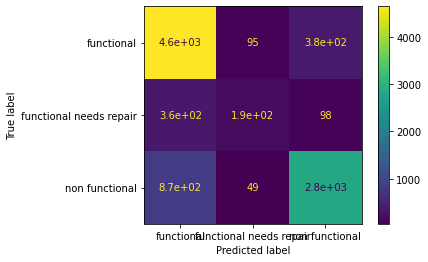

<Figure size 1440x1440 with 0 Axes>

In [18]:
# Plot 3x3 confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model_rf, X_val,y_val)


Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [20]:
# Print classification report 
print(classification_report(y_val,model_rf.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.84      5118
functional needs repair       0.57      0.29      0.39       651
         non functional       0.85      0.75      0.80      3735

               accuracy                           0.80      9504
              macro avg       0.74      0.65      0.68      9504
           weighted avg       0.80      0.80      0.80      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [31]:
data = {'y_val': y_val,
        'y_pred_prob': model_rf.predict_proba(X_val)[:,-1]}
test = pd.DataFrame(data)
test['y_val'] = test['y_val'].str.replace(' ', '_')

In [48]:
list1 = []
for i in range(len(test['y_pred_prob'])):
  if (test.iloc[i,1] >= 0.85) & (test.iloc[i,0] == 'non_functional'):
    list1.append(test.iloc[i,:])

In [51]:
X_test_nf = pd.DataFrame(list1)
X_test_nf

,y_val,y_pred_prob
944.0,non_functional,0.938462
32439.0,non_functional,0.990852
44469.0,non_functional,0.976923
68269.0,non_functional,0.859243
67278.0,non_functional,1.000000
...,...,...
64342.0,non_functional,1.000000
62211.0,non_functional,0.869958
48955.0,non_functional,0.967424
46500.0,non_functional,0.987851


In [37]:
test.head()

,y_val,y_pred_prob
id,,
20217.0,functional,0.110005
67143.0,functional,0.097073
2948.0,functional,0.125761
40301.0,non_functional,0.307609
61519.0,functional,0.068526


In [39]:
test.iloc[1,1]

0.09707292707292707

**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
result.loc[result['y_pred_prob'] > 0.85,'y_pred_prob'] = 1
result.loc[result['y_pred_prob'] <= 0.85,'y_pred_prob'] = 0

# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).